# Fetching Simple Electron Data

This demo uses ServiceX to fetch electron data from an ATLAS `Z->ee` xAOD dataset.

## Setup

You need to have an instance of `servicex` up and running. In this case, two ports need be open on the local machine - 5000 for the app, and 9000 for the object store. As of this release, that normally means `port-forward`ing from the `k8` cluster that is hosting `servicex`.

In [1]:
from func_adl import EventDataset
from func_adl_xAOD import use_exe_servicex

import uproot_methods
import matplotlib.pyplot as plt

import datetime

Next thing you need is an endpont. This is for a cache that is setup in a docker container. But you can point directly at the service (the protocal is identical):

In [2]:
end_point = 'http://localhost:5000/servicex'

## Fetching the data

In [3]:
ds = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')

In [4]:
leptons_per_event = ds \
        .Select('lambda e: (e.Electrons("Electrons"), e.Muons("Muons"))') \
        .Select('lambda ls: (ls[0].Select(lambda e: e.pt()), ls[0].Select(lambda e: e.eta()), ls[0].Select(lambda e: e.phi()), ls[0].Select(lambda e: e.e()),ls[1].Select(lambda m: m.pt()), ls[1].Select(lambda m: m.eta()), ls[1].Select(lambda m: m.phi()), ls[1].Select(lambda m: m.e()))') \
        .AsAwkwardArray(('ElePt', 'EleEta', 'ElePhi', 'EleE', 'MuPt', 'MuEta', 'MuPhi', 'MuE')) \
        .value(executor=lambda a: use_exe_servicex(a, endpoint=end_point))

In [5]:
v_particles = uproot_methods.TLorentzVectorArray.from_ptetaphi(
    leptons_per_event[b'ElePt'], leptons_per_event[b'EleEta'],
    leptons_per_event[b'ElePhi'], leptons_per_event[b'EleE'],
    )

In [6]:
v_particles = v_particles[v_particles.counts >= 2]
diparticles = v_particles[:, 0] + v_particles[:, 1]

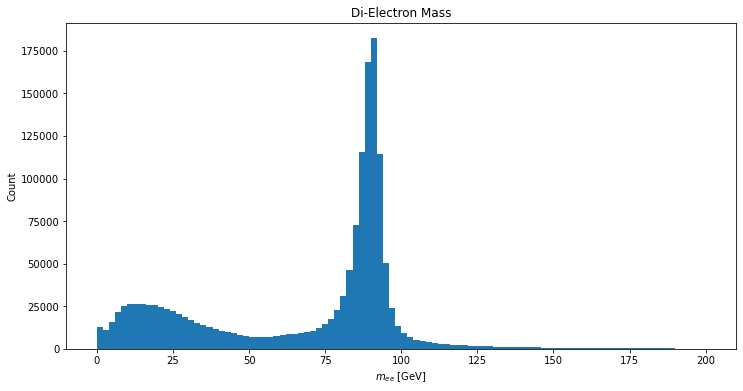

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(diparticles.mass/1000.0, bins=100, range=(0,200))
plt.title('Di-Electron Mass')
plt.xlabel('$m_{ee}$ [GeV]')
plt.ylabel('Count')
plt.show()